<a href="https://colab.research.google.com/github/karencfisher/face_express/blob/main/notebooks/conv_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data is from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The ```icml_face_data.csv``` dataset which contains a total of 34034 samples. It contains 3 columns. The target label is an integer (0, 6), the seven basic emtions:

```
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
```

The images are stored in the 'pixels' column, as a string of 2304 integer values (0, 255) separated by spaces. These will need be coverted into an array of integer values. Subsequently, they will be needs reshaped into 3-d numpy arrays to be input to the CNN.



In [3]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    # Not using the 'usage' column, so can be dropped
    df.drop('usage', axis=1, inplace=True)
    
    return df

In [4]:
df = loadCleanData('/content/drive/MyDrive/face express data/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [5]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

There is some imbalance in the target classes. 'Happy' is by far the majority class; 'Disgust' is very under-represented. 

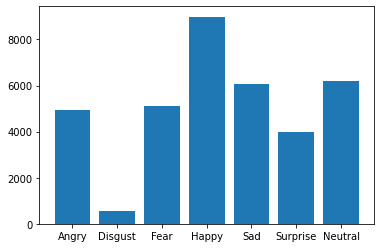

In [6]:
plt.bar(classes, df['emotion'].value_counts().sort_index());

Look at a randomly selected example.

In [7]:
def displayImage(df, classes):
    index = np.random.randint(0, df.shape[0])
    img = np.array(df.iloc[index]['pixels'])
    n = int(np.sqrt(len(df.iloc[0]['pixels'])))
    img = img.reshape(n, n)
    
    plt.imshow(img, cmap='gray')
    plt.xlabel(classes[df.iloc[index]['emotion']])
    plt.show()
    

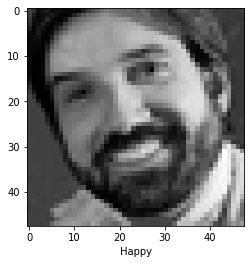

In [8]:
displayImage(df, classes)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

Split into training and testing sets.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df['pixels'],
                                                    df['emotion'],
                                                    test_size=0.2,
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28709,), (7178,), (28709,), (7178,))

Base model: guessing the classification purely by chance. 

In [11]:
clf = DummyClassifier()
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
print(f'Total baseline = {round(score * 100, 2)} %')

Total baseline = 17.61 %


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.



Normalize the image data to in range (0, 1). We will also first have to transform lists of integers to a 2-d numpy array, and then reshape that into the 4-d array (m, h, w, c) as neede by the convolutional layers.

In [12]:
# transform lists of integers into numpy arrays, and normalize the values
x_train = np.vstack(x_train) / 255
x_test = np.vstack(x_test) / 255

# reshape arrays into (m, h, w, c). As they are square, we can get the height
# and width values as a square root of the length the original 1-d array.
n = int(np.sqrt(x_train.shape[1]))
x_train = x_train.reshape(x_train.shape[0], n, n, 1)
x_test = x_test.reshape(x_test.shape[0], n, n, 1)

# Convert the pandas series of target classes to numpy array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [13]:
x_train.shape

(28709, 48, 48, 1)

Build the convolutional model. Inspired by VGG Net.

https://colab.research.google.com/drive/1XiJ-sa5Kg324mpq_XG_JMWOlfj_DvZFv



In [52]:
model = Sequential([Conv2D(64, (3, 3), input_shape=x_train.shape[1:], activation='relu'),
                    BatchNormalization(),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(512, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(512, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((2, 2), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(0.3),
                    Dense(256, activation='relu'),
                    Dropout(0.3),
                    Dense(64, activation='relu'),
                    Dropout(0.3),
                    Dense(7, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_48 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_49 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 22, 22, 128)      

To address the imbalance in some of the classes, we will try a couple of approaches to calculate the class weights. The second seemed to be more effective.

In [20]:
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 1.0335901497695852, 1: 9.216372391653291, 2: 1.0057100819729559, 3: 0.5677305806043348, 4: 0.8426722240159676, 5: 1.2788542919506436, 6: 0.8335946573751452}


Alternate class weight computations. From third solution in:

https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras



In [21]:
import math

def create_class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

class_counts = {i : np.bincount(y_train)[i] for i in range(len(classes))}
print(class_counts)
alt_class_weights = create_class_weight(class_counts)
print(alt_class_weights)

{0: 3968, 1: 445, 2: 4078, 3: 7224, 4: 4867, 5: 3207, 6: 4920}
{0: 1.0, 1: 2.269771674387058, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


Training the model. Employ also early stopping and model checkpoint

In [53]:
stop = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/face express data/weights.h5', 
                             monitor='val_acc', save_best_only=True, 
                             save_weights_only=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

history = model.fit(x_train,
          y_train,
          class_weight=alt_class_weights,
          validation_data=(x_test, y_test),
          epochs=100,
          batch_size=128,
          callbacks=[stop, checkpoint])

Epoch 1/100
225/225 [==============================] - 18s 78ms/step - loss: 1.9725 - acc: 0.2214 - val_loss: 1.8288 - val_acc: 0.2459
Epoch 2/100
225/225 [==============================] - 17s 78ms/step - loss: 1.7600 - acc: 0.3177 - val_loss: 1.9147 - val_acc: 0.2576
Epoch 3/100
225/225 [==============================] - 17s 76ms/step - loss: 1.5769 - acc: 0.4068 - val_loss: 1.4891 - val_acc: 0.4278
Epoch 4/100
225/225 [==============================] - 17s 76ms/step - loss: 1.4487 - acc: 0.4681 - val_loss: 1.3801 - val_acc: 0.4820
Epoch 5/100
225/225 [==============================] - 17s 74ms/step - loss: 1.3612 - acc: 0.5069 - val_loss: 1.3682 - val_acc: 0.4709
Epoch 6/100
225/225 [==============================] - 17s 76ms/step - loss: 1.3003 - acc: 0.5327 - val_loss: 1.2186 - val_acc: 0.5376
Epoch 7/100
225/225 [==============================] - 17s 77ms/step - loss: 1.2597 - acc: 0.5511 - val_loss: 1.1949 - val_acc: 0.5573
Epoch 8/100
225/225 [==============================] - 

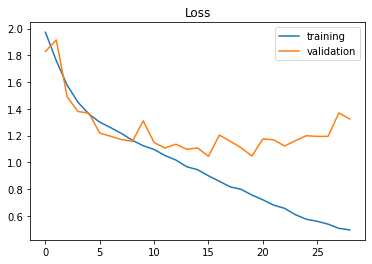

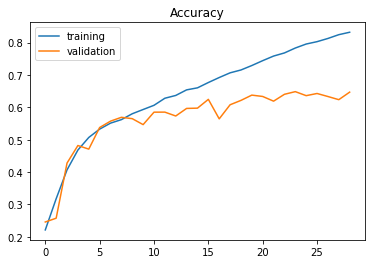

In [54]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

In [55]:
from sklearn.metrics import confusion_matrix


In [56]:
import seaborn as sns

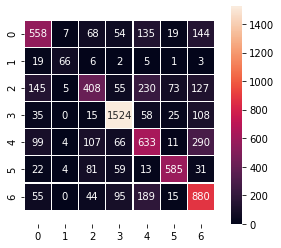

In [57]:
preds = model.predict(x_test)
y_pred = [np.argmax(pred) for pred in preds]
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);


Looks reasonable, save the model

In [58]:
model.save('/content/drive/MyDrive/face express data/model.h5')

Alternatively, load a model that has been trained and saved.

In [59]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/face express data/model.h5')


In [60]:
preds = model.predict(x_test)
y_pred = [np.argmax(pred) for pred in preds]
accuracy_score(y_test, y_pred)

0.6483700195040402

Perform inference on a random selected sample from the test dataset

In [33]:
def tryRandomExample():
    index = np.random.randint(0, x_test.shape[0])
    img = x_test[index]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    best = np.argmax(pred[0])
    
    print(classes[best] == classes[y_test[index]])
    print(f'Predicted label: {classes[best]}\nConfidence: {round(pred[0][best] * 100, 2)} %')
    print(f'Actual label: {classes[y_test[index]]}')
    
    plt.imshow(np.squeeze(img[0], axis=-1), cmap='gray')
    plt.show()
    
    df = pd.DataFrame(dict(probs=list(pred[0]), labels=classes))
    fig = px.line_polar(df, r='probs', theta='labels', line_close=True)
    fig.show()
    
    

True
Predicted label: Happy
Confidence: 99.98 %
Actual label: Happy


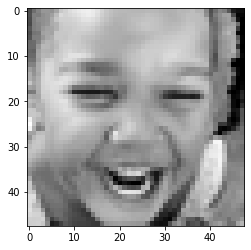

In [63]:
tryRandomExample()